# BOS法  
ナイフエッジを使わないシュリーレン法。背景に縞模様を置いておき、参照画像と測定画像の2枚用意する。  
その差分から位相変調を算出する。  
参考  
[Background Oriented Schlieren法に基づく密度勾配の可視化法の改良](https://www.jstage.jst.go.jp/article/kikaib/77/784/77_784_2391/_article/-char/ja/)  

In [1]:
import rawpy
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [2]:
ref_path = Path("data/DSC_0013.NEF")
jet_path = Path("data/DSC_0012.NEF")

デフォルトのガンマ補正式
$$V=\begin{cases}4.500L & L < 0.018\\1.099L^{0.45}-0.099 & L \geq0.0180\end{cases}$$

## デコード  
postprocessの引数  

|引数名|型|default|説明|
|:---:|:---:|:---:|:---|
|demosaic_algorithm||None|デモザイキングアルゴリズムの指定。デフォルト設定はAHD。|
|half_size|bool|False|画像を縦横半分のサイズで出力します。2×2ブロックを補間せずに1画素にします。(Green チャネルは多分平均)|
|four_color_rgb|bool|False|2つのグリーンチャネルを独立に補間して処理するか否かのフラグ|
|dcb_iterations|int|0|DCBにおける補正処理する回数。DCBデモザイキングアルゴリズムを使う際に必要|
|dcb_enhance|bool|False|DCB補間における補間された色の強調をするか否か|
|fbdd_noise_reduction| |FBDDNoiseReductionMode.Off|デモザイキング前のFBDDノイズ除去処理モード。モードは全部で、Full、Light、Offの3種類存在する。|
|noise_thr|float|None|ウェーブレットノイズ除去の閾値|
|median_filter_passes|int|0|色のアーティファクトを削減するための、デモザイキング後のメディアンフィルタの回数|
|use_camera_wb|bool|False|カメラで取得されたホワイトバランスの値を用いるか否かのフラグ|
|use_auto_wb|bool|False|自動で計算されたホワイトバランスを使うか否かのフラグ|
|user_wb|list|None|長さ４のリストを指定。4色それぞれのホワイトバランスの値を指定する。|
| | | |もしcamera_wbもauto_wbもFalseでuser_wbがNoneの場合には、daylight wbを使用します。もしcamera_wbもauto_wbもTrueならばauto_wbを優先します。|
|output_color| |ColorSpace.sRGB|出力の色空間。ColorSpaceはraw, sRGB, Adobe, Wide, ProPhoto, XYZ の6種類が存在する。|
|output_bps|int|8|出力の画素値ビット数。8か16を指定|
|user_flip|int|None|0=none, 3=180, 5=90CCW, 6=90CW, デフォルトは可能であればRaw画像の向きを使用する。ちなみに90CWは時計回りに90度回転、90CCWは反時計回りに90度回転。|
|user_black|int|None|カスタムブラックレベルの指定（値は一つしか指定できない）|
|user_sat|int|None|飽和させる値の調整|
|no_auto_scale|bool|False|画素値のスケーリングをするか否かのフラグ。デフォルトはFalseでスケーリングするの意味|
|no_auto_bright|bool|False|輝度の自動調整（明るい方向への自動調整）を行うか否かのフラグ。デフォルトはFalseで自動調整が入る。|
|auto_bright_thr|float|None|no_auto_bright=True時、輝度の自動調整を使用する際の、最大値でクリップする画素の比率。デフォルトは0.01(1%)の画素を最大値でクリップさせる。|
|adjust_maximum_thr|float|0.75|librawのドキュメントを見よ|
|bright|float|1.0|明るさのスケーリング。|
|highlight_mode||HighlightMode.Clip|ハイライトモード。HighlightModeは、Clip, Ignore, Blend, Reconstruct, ReconstructDefault の5種類存在する。|
|exp_shift|float|None|線形な露出のシフト。使用可能レンジは0.25(2段暗くなる)から8.0(3段明るくなる)。（0.25, 0.5, 1, 2, 4, 8でステップを刻むと思われる)|
|exp_preserve_highlights|float|0|exp_shiftによる露光シフトを行った際に、ハイライトを保存する量を指定する。0.0から1.0(全保存)まで指定。|
|gamma|tuple|None|2つの値の配列で指定。パワーとスロープ（傾き）を指定する。デフォルトはBT.709にあたる(2.222, 4.5)|
|chromatic_aberration|tuple|None|赤、青のスケーリング値を(赤のスケール、青のスケール)で指定する。デフォルトは補正無しに相当する(1,1)。赤と青の収差をそれぞれの色をスケーリングすることで補正する。|
|bad_pixels_path|str|None|dcrawにより使用できない画素（点灯しっぱなし画素、点灯しない画素）ファイルのデータのパス。それぞれの使用できない画素の値は周囲の画素の平均を使って補正される。他にも補正関数は用意されている。|


In [3]:
def postproccesing(path):
    raw = rawpy.imread(str(path))
    return raw.postprocess(gamma=[1.0,1.0],
                               no_auto_bright=True,
                               output_color=rawpy.ColorSpace.raw,
                               use_camera_wb=True,
                               use_auto_wb=False,
                               output_bps=16,
                                no_auto_scale=True
                              )

In [4]:
ref_img = postproccesing(ref_path)

In [5]:
jet_img = postproccesing(jet_path)

In [6]:
ref_gray = ref_img[:,:,1]

In [7]:
jet_gray = jet_img[:,:,1]

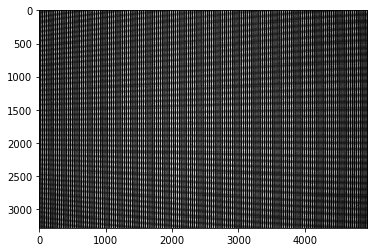

In [8]:
fig,axes = plt.subplots()
axes.imshow(ref_gray,cmap="gray")

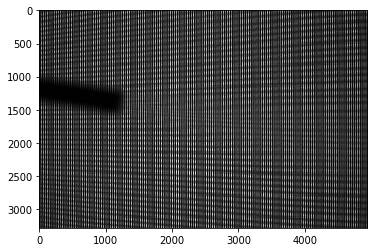

In [9]:
fig,axes = plt.subplots()
axes.imshow(jet_gray,cmap="gray")

In [247]:
bos = (jet_gray-ref_gray) * np.gradient(ref_gray,axis=0)

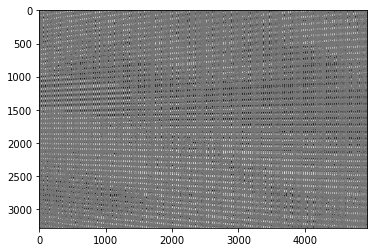

In [248]:
fig,axes = plt.subplots()
axes.imshow(bos,cmap="gray")

In [336]:
lpf = cv2.blur(bos,(100,100))

In [337]:
lpf -= np.min(lpf)

In [338]:
lpf /= np.amax(lpf)

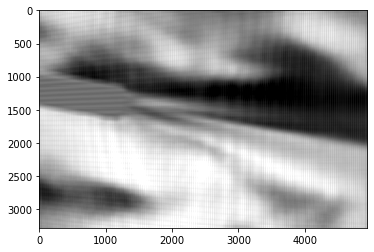

In [339]:
fig,axes = plt.subplots()
axes.imshow(lpf,vmin=0.1,vmax=0.9,cmap="gray")